In [1]:
import io
import requests
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import ipywidgets as widgets
import scipy
from scipy import special
import time
from scipy.signal import convolve as conv

# %matplotlib notebook

plt.style.use(plt.style.available[20])
plt.style.use("https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/plots_style.txt")

# Reinforcement learning

Today we want to investigate some RL algorithms and how they can be used to train an agent that moves around in a grid environment.

## The cliff
<div>
<img src="https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/notebooks/Exc_12/static/gridworld_setup.png" width="550"/>
</div>

The agent should get to the goal with as few steps as possible without falling into the cliff.

In order to invesigate the agents behavior we first setup the viusal representation of the environment:

(You do not have to go through the code, you can also just execute the cell below)

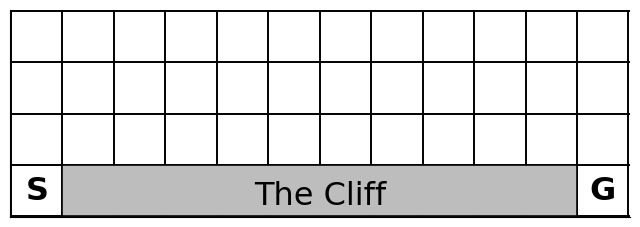

In [2]:
def show_grid_world(ax=None):
    if ax == None:
        fig, ax = plt.subplots(figsize=(8,6))



    ax.grid(linewidth = 1.4, c='k')
    ax.set(
        xticks = [0.5+ii for ii in range(-1,12)],
        yticks = [0.5 + ii for ii in range(-1,4)],
        xlim=[-0.52,11.53],
        ylim = [-0.51,3.52])


    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    ax.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False) # labels along the bottom edge are off

    ax.set_aspect('equal', adjustable='box')
    rect=mpatches.Rectangle((0.51,-0.48),9.98,0.96, 
                            fill=True,
                            color="#bdbdbd",zorder=50)
    ax.add_patch(rect)

    ax.annotate('S',(0,0), fontweight='bold',fontsize=23,ha='center',va='center',zorder=80)
    ax.annotate('G',(11,0), fontweight='bold',fontsize=23,ha='center',va='center',zorder=80)
    ax.annotate('The Cliff',(5.5,-0.1), fontsize=23,ha='center',va='center',zorder=80)
    return ax
show_grid_world();

## Moving in the environment

The agent is able to move in the environment

Below you can use the widget to see how we can map the states to a position in the 2d grid



In [5]:
def move_states(state):
    fig, ax = plt.subplots(figsize=(8,3))
    show_grid_world(ax)
    agent = ax.scatter(state%12,state//12,s=800,c='b',zorder=60)
    print (f'state {state}:      x = {state%12}, y = {state//12}')

widgets.interactive(move_states, state = (0,47,1))

interactive(children=(IntSlider(value=23, description='state', max=47), Output()), _dom_classes=('widget-inter…

## programming the environment

We need to define how the agent moves in the environment, following the four possible actions.

The agent can either move right (0), down (1), left (2) or up (3)
If the agent moves against a well, it will stay at the current state.
We implement this with if-cases


In [ ]:
def take_action(state, action):
        
    if action == 0:  # move right
        next_state = state + 1
        if state % 12 == 11:  # right border
            next_state = state
            
    elif action == 1:  # move down
        next_state = state - 12
        if state <= 11:  # bottom border
            next_state = state
    
    elif action == 2:  # move left
        next_state = state - 1
        if state % 12 == 0:  # left border
            next_state = state
            
    elif action == 3:  # move up
        next_state = state + 12
        if state >= 36:  # top border
            next_state = state
    
    else:
        print("Action must be between 0 and 3.")
        return None

    return int(next_state)

## Test whether the agent moves as we wish
We can now test whether the actions have the correct effect in the world, if you execute the cell below the agent will execute a couple of random actions in the environment.
For now we only care for the fact that an action (indicated by an arrow) should lead to the state we expect in the next step. 

In [ ]:
def setup_visualization(state = 0):

    fig, ax = plt.subplots(figsize=(8,3))
    show_grid_world(ax)
    state_2d = [state%12,state//12] 
    agent = ax.scatter(state_2d[0],state_2d[1],s=800,c='b',zorder=60)
    arrow = ax.annotate("",
                  xy=(0, 1), xycoords='data',
                  xytext=(1, 1), textcoords='data',
                  arrowprops=dict(#arrowstyle="-",
                                  connectionstyle="arc3,rad=0.",
                                  linewidth=4, fc='k'),
                        zorder = 100,
                        annotation_clip = False
                  )
    
    return fig, ax, agent, arrow


state = 0
n_steps = 100
all_actions = []
all_states = [state]

for ii in range(n_steps):
   
    action = np.random.choice(4)
    state = take_action(state, action)
    
    all_actions.append(action)
    all_states.append(state)
    
    
def visualize_taken_actions(agent, all_states, all_actions, state_index=0):
   
    state = all_states[state_index]
    action = all_actions[state_index]
    
    x = state%12
    y =state//12
  
    if action == 0:
        target_x, target_y = x + 1, y
    if action == 1:
        target_x, target_y = x, y - 1
    if action == 2:
        target_x, target_y = x - 1, y
    if action == 3:
        target_x, target_y = x, y + 1
    
    fig, ax, agent, arrow = setup_visualization(state )
    
    arrow.xy = (target_x ,target_y )
    arrow.set_position([x,y])
    agent.set_offsets([x,y])
    

widgets.interactive(visualize_taken_actions, state_index = (0,len(all_states)-2,1), 
                    agent=widgets.fixed(agent),
                    all_states=widgets.fixed(all_states),
                    all_actions=widgets.fixed(all_actions),
                    arrow = widgets.fixed(arrow),
                    
                   )


## Rewards

Next we need to define the rewards the agent recieves for reaching a certain state

In [ ]:
def get_reward(state):
    
    if state >= 1 and state <= 10: # cliff
        return -100
    elif state == 11: # goal
        return 0
    else:
        return -1 

## Episode
Now we can define an episode. 

Here, we look at an episodic task. This means that the agent can reach an endpoint (in this case the goal or the cliff) and thereby stops the current episode. However, it can be started again ...

### Task 1
Go throught he code and make sure that you understand how the episode is implemented and what the stopping conditions are.

Then execute the cell and see how well the agent performs with the random policy we provide.
(reminder: the policy describes the mapping from a state to an action. In our case, the action is just randomly selected)

In [ ]:
def random_policy(**kwargs):
    return np.random.choice(4)


def run_episode(policy, state=0):
        
    all_actions = []
    all_states = [state]
    
    max_steps = 2000
    reward_sum = 0
        
    for t in range(max_steps):
        # choose next action
        action = policy(state=state,q = state_action_values[state])
        all_actions.append(action)

        # observe outcome of action on environment
        next_state = take_action(state, action)
        reward = get_reward(next_state)

        # sum rewards obtained
        reward_sum += reward

        if reward == -100 or reward == 0:
            break  # episode ends
        state = next_state
        
        all_states.append(state)
     
    return all_states, all_actions, reward_sum
    

state = 0 
all_states, all_actions, reward_sum = run_episode(policy=random_policy, state = state)
ax.set_title(f'Reward Sum: {reward_sum}')


    
widgets.interactive(visualize_taken_actions, state_index = (0,len(all_states)-1,1), 
                    agent=widgets.fixed(agent),
                    all_states=widgets.fixed(all_states),
                    all_actions=widgets.fixed(all_actions)
                    
                   )

We can see that the random approach is not very efficient. We need a better policy!

### Task 2

Can you program a policy that always reaches the goal? Be creative!

### [Solution 2](https://raw.githubusercontent.com/comp-neural-circuits/intro-to-comp-neuro/dev/notebooks/Exc_12/solutions/ade42d1ac53626e9723fe2ae7ca52865.txt)

## State-action values

We now want to learn the value function of the environment. More specifically, in this case we are going to learn the state-action values. 

First, we write a function to display the state-action values in the grid world.

Every state has four state-action values and we are especially interested in the best one per state. Therefore we will display the values as colored triangles and the best action of each state will be a circle:

(You don't have to necessarily go through the code)


In [ ]:
def show_state_action_values_in_grid(ax = None, min_val = 0, max_val = 0, state_action_values=np.random.rand(48,4)):
        
        fig, (ax, cax) = plt.subplots(2,1, gridspec_kw={'height_ratios': [15,1]})
        
        
        cmap = mpl.cm.hot
        norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)

#         self.state_action_values = -100*np.random.rand(self.n_states,4)
        
        ax = show_grid_world(ax=ax)
        cax.grid(False)
        cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')
        cax.set_title("State-action value")
        
        # the four triangle paths for the four actions
        triangle_paths = np.array([
            [[0.55,0.5],[0.95,0.95],[0.95,0.05]],
            [[0.5,0.45],[0.9,0.05],[0.1,0.05]],
            [[0.45,0.5],[0.05,0.05],[0.05,0.9]],
            [[0.5,0.55],[0.05,0.95],[0.9,0.95]]           
        ])
        
        for state in range(state_action_values.shape[0]):
            
            for action in range(4):
                
                state_2d = np.array([state%12,state//12]).astype(float)
                
                path = triangle_paths[action]+state_2d - np.array([0.5,0.5])
                # convert the state-value to color 
                color = cmap(norm(state_action_values[state,action]))
                
                if np.argmax(state_action_values[state]) == action:
                    ax.scatter(*np.mean(path,axis=0),color=color, edgecolor='k',linewidth=0.5, s=60)
                else:
                    triang=mpatches.Polygon(path,
                                    fill=True,
                                    color=color,zorder=10)
                    
                    ax.add_patch(triang)
        plt.tight_layout()
                    

When executing the cell below you can look at an example (just random values)

In [ ]:
show_state_action_values_in_grid(ax = None, min_val = 0, max_val = 1, state_action_values=np.random.rand(48,4))

## The policy ($\epsilon$-greedy)

In order to perform better (and to learn faster), we need to have a policy that can make use of the state-action values (and is better than the random policy).

A policy that is often used is called $\epsilon$-greedy

In this policy, we usually take the best action, but in a fraction $\epsilon$ we select a random action. 
This ensures that the agent keeps exploring, but on average it tries to select the best possible action. 

In [ ]:
def epsilon_greedy(q, epsilon):
    
    if np.random.random() > epsilon:
        action = np.argmax(q)
    else:
        action = np.random.choice(len(q))

        
    return action

## The learning rule

Even more important than the policy is the learning rule (algorithm) that we want to use to update the state-action values.

We learned a couple of variants in the lecture, here we select q-learning.

<div>
<img src="https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/notebooks/Exc_12/static/q_learning.png" width="750"/>
</div>


Make sure that you understand how the equation above is implemented in the function below

In [ ]:
def q_learning(state, action, reward, next_state, state_action_values, params):
    # Q-value of current state-action pair
    q = state_action_values[state, action]
    
    if reward in [-100,0]: # this means the episode ends
        max_next_q = 0
    else:
        max_next_q = np.max(state_action_values[next_state])

    # write the expression to compute the TD error
    td_error = reward + params['gamma'] * max_next_q - q
    # write the expression that updates the Q-value for the state-action pair
    state_action_values[state, action] = q + params['alpha'] * td_error

    return state_action_values # we also return the state_values (although not changed) 

## Learning

Now we have all the ingredients to implement the function that allows the agent to learn to move in the environment.


1 - we initiate the state-action values (just set all to one) 
(question: What could be the advantage if we initiate them all to -200?)

2 - We loop through all the episodes we want to run for our learning

3 - in each episode we select and action based on the policy

4 - we take that action (and move to the next state)

5 - we receive a reward 

6 - we update the state value based on q-learning

7 - we check whether the episode ended

make sure that you understand the implementation

In [ ]:
def learn_environment(n_episodes, params, max_steps=400):
               
    # initiate the state-action values
    state_action_values = np.ones((48,4))

    # Loop over episodes
    for episode in range(n_episodes):
        state = 0  # initialize state, we start at state 0


        for t in range(max_steps):
            # choose next action
            action = epsilon_greedy(q = state_action_values[state], 
                             epsilon = params['epsilon'])
            # observe outcome of action on environment
            next_state = take_action(state, action)
            reward = get_reward(next_state)

            # update value function
            state_action_values = q_learning(
                state, 
                action, 
                reward, 
                next_state, 
                state_action_values, 
                params
            )

            if reward in [-100, 0]:
                break  # episode ends
            state = next_state
    return state_action_values

## Execute the learning

we can now run the learning algorithm and look at the learned state-action values

In [ ]:
params = {
  'epsilon': 0.1,  # epsilon-greedy policy
  'alpha': 0.1,  # learning rate
  'gamma': 0.8,  # discount factor
}
state_action_values = learn_environment(n_episodes=400, params=params, max_steps=400)
show_state_action_values_in_grid(ax = None, min_val = -8, max_val = 1, state_action_values=state_action_values)

We can now see a couple of things from the learned values:

1 - The actions that lead into the cliff are learned to be extremely bad

2 - can you see the path the agent would take if it follows the greedy policy?

## Greedy policy

We can now use the greedy policy to select the best action at every timestep. 



In [ ]:
def greedy(q, **kwargs):
    action = np.argmax(q)
    return action


state = 0 
all_states, all_actions, reward_sum = run_episode(policy=greedy, state = state)
ax.set_title(f'Reward Sum: {reward_sum}')


    
widgets.interactive(visualize_taken_actions, state_index = (0,len(all_states)-1,1), 
                    agent=widgets.fixed(agent),
                    all_states=widgets.fixed(all_states),
                    all_actions=widgets.fixed(all_actions)
                    
                   )

## Different learning algorithms

We now want to investigate different learning algorithms, therefore we put everything we wrote above into a class

In [ ]:
class CliffWorld(object):
    def __init__(self, grid_length = 12, grid_height = 4):
        self.init_state = 0
        self.max_steps = 2000
        
        self.grid_length = grid_length
        self.grid_height = grid_height
        
        self.n_states = self.grid_length * self.grid_height 
        self.n_actions = 4
        
        
        # initialize state and state-action values
        self.state_values = np.zeros(self.n_states)
        self.state_action_values = np.zeros((self.n_states,self.n_actions))
    
    
    def run_episode(self, policy):
        
        
        state = self.init_state
        all_actions = []
        all_states = [state]

        
        reward_sum = 0

        for t in range(self.max_steps):
            # choose next action
            action = policy()
            all_actions.append(action)

            # observe outcome of action on environment
            next_state = take_action(state, action)
            reward = get_reward(next_state)

            # sum rewards obtained
            reward_sum += reward

            if reward == -100 or reward == 0:
                break  # episode ends
            state = next_state

            all_states.append(state)
        
        self.all_states, self.all_actions, self.reward_sum = all_states, all_actions, reward_sum
                    
        return all_states, all_actions, reward_sum
                    
    
    def show_last_run_interactive(self):
           
        
        fig, ax, agent, arrow = self.setup_visualization()    
        ax.set_title(f'Reward Sum: {self.reward_sum}')
        
        
        wgt = widgets.interactive(self.visualize_taken_actions, state_index = (0,len(self.all_states)-1,1), 
                agent=widgets.fixed(agent),
                arrow=widgets.fixed(arrow),

               )
        
        return wgt

    
    def show_state_values_in_grid(self, ax = None, min_val = 0, max_val = 0):
        
        fig, (ax, cax) = plt.subplots(2,1, gridspec_kw={'height_ratios': [15,1]})
        
        
        cmap = mpl.cm.hot
        norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)

        self.state_values = -100*np.random.rand(self.n_states)
        
        ax = self.show_world(ax=ax)
        cax.grid(False)
        cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')
        cax.set_title("State value")
        for state in range(self.n_states):
            state_2d = np.array([state%self.grid_length,state//self.grid_length]).astype(float)
            state_2d -= np.array([0.47,0.47])
            
            # convert the state-value to color 
            color = cmap(norm(self.state_values[state]))
            rect=mpatches.Rectangle(state_2d,width=0.94,height=0.94, 
                                fill=True,
                                color=color,zorder=10)
            ax.add_patch(rect)
            
    def show_state_action_values_in_grid(self, ax = None, cax = None, min_val = 0, max_val = 0):
        
        if ax == None or cax == None:
            fig, (ax, cax) = plt.subplots(2,1, gridspec_kw={'height_ratios': [15,1]})
        
        
        cmap = mpl.cm.hot
        norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)

#         self.state_action_values = -100*np.random.rand(self.n_states,4)
        
        ax = self.show_world(ax=ax)
        cax.grid(False)
        cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')
        cax.set_title("State-action value")
        
        # the four triangle paths for the four actions
        triangle_paths = np.array([
            [[0.55,0.5],[0.95,0.95],[0.95,0.05]],
            [[0.5,0.45],[0.9,0.05],[0.1,0.05]],
            [[0.45,0.5],[0.05,0.05],[0.05,0.9]],
            [[0.5,0.55],[0.05,0.95],[0.9,0.95]]           
        ])
        
        for state in range(self.n_states):
            
            for action in range(4):
                
                state_2d = np.array([state%self.grid_length,state//self.grid_length]).astype(float)
                
                path = triangle_paths[action]+state_2d - np.array([0.5,0.5])
                # convert the state-value to color 
                color = cmap(norm(self.state_action_values[state,action]))
                
                if np.argmax(self.state_action_values[state]) == action:
                    ax.scatter(*np.mean(path,axis=0),color=color, edgecolor='k')
                else:
                    triang=mpatches.Polygon(path,
                                    fill=True,
                                    color=color,zorder=10)
                    
                    ax.add_patch(triang)
                
    
    
    
    def take_action(self, state, action):
        
        if action == 0:  # move right
            next_state = state + 1
            if state % self.grid_length == self.grid_length-1:  # right border
                next_state = state

        elif action == 1:  # move down
            next_state = state - self.grid_length
            if state <= self.grid_length-1:  # bottom border
                next_state = state

        elif action == 2:  # move left
            next_state = state - 1
            if state % self.grid_length == 0:  # left border
                next_state = state

        elif action == 3:  # move up
            next_state = state + self.grid_length
            if state >= self.grid_length * self.grid_height:  # top border
                next_state = state

        else:
            print("Action must be between 0 and 3.")
            return None

        return int(next_state)
    
    
    def get_reward(self, state):
    
        if state >= 1 and state < self.grid_length-1: # cliff
            return -100
        elif state == 11: # goal
            return 0
        else:
            return -1 
        
    def show_world(self, ax=None):
        if ax == None:
            fig, ax = plt.subplots(figsize=(8,6))



        ax.grid(linewidth = 1.4, c='k')
        ax.set(
            xticks = [0.5+ii for ii in range(-1,12)],
            yticks = [0.5 + ii for ii in range(-1,4)],
            xlim=[-0.52,11.53],
            ylim = [-0.51,3.52])


        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
        ax.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,         # ticks along the top edge are off
            labelleft=False) # labels along the bottom edge are off

        ax.set_aspect('equal', adjustable='box')
        rect=mpatches.Rectangle((0.51,-0.48),9.98,0.96,
                                fill=True,
                                color="#bdbdbd",zorder=50)
        ax.add_patch(rect)

        ax.annotate('S',(0,0), fontweight='bold',fontsize=23,ha='center',va='center', zorder=12)
        ax.annotate('G',(11,0), fontweight='bold',fontsize=23,ha='center',va='center', zorder=12)
        ax.annotate('The Cliff',(5.5,-0.1), fontsize=23,ha='center',va='center',zorder=200)
        return ax
        
    def visualize_taken_actions(self, state_index, agent, arrow):
   
        state = self.all_states[state_index]
        action = self.all_actions[state_index]

        x = state%12
        y =state//12

        if action == 0:
            target_x, target_y = x + 1, y
        if action == 1:
            target_x, target_y = x, y - 1
        if action == 2:
            target_x, target_y = x - 1, y
        if action == 3:
            target_x, target_y = x, y + 1

        arrow.xy = (target_x ,target_y )

        arrow.set_position([x,y])
        agent.set_offsets([x,y])
                    
    def setup_visualization(self, state = 0):

        fig, ax = plt.subplots(figsize=(8,3))
        self.show_world(ax)
        state_2d = [self.init_state%12,self.init_state//12] 
        agent = ax.scatter(state_2d[0],state_2d[1],s=800,c='b',zorder=60)
        arrow = ax.annotate("",
                      xy=(0, 1), xycoords='data',
                      xytext=(1, 1), textcoords='data',
                      arrowprops=dict(#arrowstyle="-",
                                      connectionstyle="arc3,rad=0.",
                                      linewidth=4, fc='k'),
                            zorder = 100,
                            annotation_clip = False
                      )

        return fig, ax, agent, arrow
    
    def initiate_values(self, initiation_keyword):
        
        if initiation_keyword == 'ones':
            
            self.state_values = np.ones(self.n_states)
            self.state_action_values = np.ones((self.n_states,self.n_actions))
    
    def learn_environment(self,  learning_rule, policy, params, n_episodes,
                          initiation_keyword='ones',):
               
        self.initiate_values(initiation_keyword)

        # Run learning
        reward_sums = np.zeros(n_episodes)
    
    
        



        # Loop over episodes
        for episode in range(n_episodes):
            state = self.init_state  # initialize state
            reward_sum = 0
            
            next_action = policy(v = self.state_values[state], 
                                 q = self.state_action_values[state], 
                                 params = params)

            for t in range(self.max_steps):
                # choose next action
                action = next_action
                # observe outcome of action on environment
                next_state = take_action(state, action)
                reward = get_reward(next_state)
                
                next_action = policy(v = self.state_values[next_state], 
                                     q = self.state_action_values[next_state], 
                                     params = params)
                
                # update value function
                self.state_values, self.state_action_values = learning_rule(
                    state, 
                    action, 
                    reward, 
                    next_state, 
                    next_action, 
                    self.state_values,
                    self.state_action_values, 
                    params
                )

                # sum rewards obtained
                reward_sum += reward

                if reward in [-100, 0]:
                    break  # episode ends
                state = next_state

            reward_sums[episode] = reward_sum

        return reward_sums
    

We now define again the $\epsilon$-greedy policy

In [ ]:
def policy_epsilon_greedy(**kwargs):
    
    q = kwargs['q']
    
    if np.random.random() > kwargs['params']['epsilon']:
        action = np.argmax(q)
    else:
        action = np.random.choice(len(q))

        
    return action

## Off-policy vs On-policy

So far, we looked at q-learning. It is an off-policy alogorithm, since the update does not depend on the actions the agent actually takes, but on the maximum possible action of the next state. 

We now compare this approach to the SARSA algorithm, which allows on-policy learning. The learning method in the class is already modified, so that it looks at the decision of the next state before updating the state-action values

<div>
<img src="https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/notebooks/Exc_12/static/sarsa_vs_qlearning.png" width="750"/>
</div>

Below you can see the implementations of sarsa and q-learning


In [ ]:
def sarsa_learning(state, action, reward, next_state, next_action, state_values, state_action_values, params, *args):
    # Q-value of current state-action pair
    q = state_action_values[state, action]
    
    if reward in [-100,0]: # this means the episode ends
        next_q = 0
    else:
        next_q = state_action_values[next_state, next_action]

    # write the expression to compute the TD error
    td_error = reward + params['gamma'] * next_q - q
    # write the expression that updates the Q-value for the state-action pair
    state_action_values[state, action] = q + params['alpha'] * td_error
    
    return state_values, state_action_values # we also return the state_values (although not changed) 

def q_learning(state, action, reward, next_state, next_action, state_values, state_action_values, params, *args):
    # Q-value of current state-action pair
    q = state_action_values[state, action]
    
    if reward in [-100,0]: # this means the episode ends
        max_next_q = 0
    else:
        max_next_q = np.max(state_action_values[next_state])

    # write the expression to compute the TD error
    td_error = reward + params['gamma'] * max_next_q - q
    # write the expression that updates the Q-value for the state-action pair
    state_action_values[state, action] = q + params['alpha'] * td_error

    return state_values, state_action_values # we also return the state_values (although not changed) 


In [ ]:
fig, (ax_q_learning, ax_sarsa, cax) = plt.subplots(3,1, gridspec_kw={'height_ratios': [8,8,1]})
ax_q_learning.set_title('Q-learning')
ax_sarsa.set_title('SARSA')
params = {
  'epsilon': 0.1,  # epsilon-greedy policy
  'alpha': 0.1,  # learning rate
  'gamma': 0.8,  # discount factor
}

np.random.seed(42)
cliff_q_learning = CliffWorld()
cliff_q_learning.learn_environment(
    learning_rule = q_learning, 
    policy=policy_epsilon_greedy,
    params = params, 
    n_episodes = 2_000,
    initiation_keyword='ones',)
cliff_q_learning.show_state_action_values_in_grid(ax = ax_q_learning, cax=cax, min_val=-8, max_val = 0)

cliff_sarsa = CliffWorld()
cliff_sarsa.learn_environment(
    learning_rule = sarsa_learning, 
    policy=policy_epsilon_greedy,
    params = params, 
    n_episodes = 2_000,
    initiation_keyword='ones',)
cliff_sarsa.show_state_action_values_in_grid(ax = ax_sarsa, cax=cax, min_val=-8, max_val = 0)


## TD($\lambda$)

To we now implement TD($\lambda$) in the backward view with eligibility traces

In [ ]:
class CliffWorldEligibility(CliffWorld):
    def __init__(self, grid_length = 12, grid_height = 4):
        super().__init__(grid_length, grid_height)
        
    
    
    def learn_environment(self,  learning_rule, policy, params, n_episodes,
                          initiation_keyword='ones',lambda_td=0.9):
               
        self.initiate_values(initiation_keyword)
         
        # we need to add eligibiity traces for every state
        self.eligibility = np.zeros((self.n_states, self.n_actions))
        

        # Run learning
        reward_sums = np.zeros(n_episodes)

        # Loop over episodes
        for episode in range(n_episodes):
            state = self.init_state  # initialize state
            
            
            reward_sum = 0
            
            next_action = policy(state=state,
                                 v = self.state_values[state], 
                                 q = self.state_action_values[state], 
                                 params = params)
            
            print (next_action)
            
            self.eligibility[state, next_action] = 1
            

            for t in range(self.max_steps):
                # choose next action
                action = next_action
                # observe outcome of action on environment
                next_state = take_action(state, action)
                reward = get_reward(next_state)
                
                next_action = policy(state=next_state,
                                    v = self.state_values[next_state], 
                                     q = self.state_action_values[next_state], 
                                     params = params)
                
                # update value function
                self.state_values, self.state_action_values = learning_rule(
                    state, 
                    action, 
                    reward, 
                    next_state, 
                    next_action, 
                    self.state_values,
                    self.state_action_values, 
                    params,
                    self.eligibility,
                )

                # sum rewards obtained
                reward_sum += reward

                if reward in [-100, 0]:
                    break  # episode ends
                    
                self.eligibility *= lambda_td
                self.eligibility[next_state,next_action] = 1
                state = next_state
                
                
                
                

            reward_sums[episode] = reward_sum
        

        return reward_sums

In [ ]:
def sarsa_lambda_learning(state, action, reward, next_state, next_action, state_values, state_action_values, params, eligibility, *args):
    # Q-value of current state-action pair
    q = state_action_values[state, action]
    
    if reward in [-100,0]: # this means the episode ends
        next_q = 0
    else:
        next_q = state_action_values[next_state, next_action]

    # write the expression to compute the TD error
    td_error = reward + params['gamma'] * next_q - q
    # write the expression that updates the Q-value for the state-action pair
    state_action_values = state_action_values + params['alpha'] * (td_error * eligibility)
    
    return state_values, state_action_values # we also return the state_values (although not changed) 

In [ ]:
def policy_illustration_path(state, **kwargs):
    
    state_action_dict = {
        0 : 3,
        12 : 3,
        24 : 0,
        25 : 0,
        26 : 3,
        38 : 0,
        39 : 0,
        40 : 0,
        41 : 1,
        29 : 2,
        28 : 1,
        16 : 0,
        17 : 0,
        18 : 0,
        19 : 0,
        20 : 3,
        32 : 0,
        33 : 0,
        34 : 0,
        35 : 1,
        23 : 2,
        22 : 1,
        10 : 0,
        11 : 0,
    }
    
    return state_action_dict[state]

params = {
  'epsilon': 0.1,  # epsilon-greedy policy
  'alpha': 0.1,  # learning rate
  'gamma': 0.8,  # discount factor
}
cliff = CliffWorldEligibility()

def run_illustration(lambda_td=0.8):
    np.random.seed(18)
    cliff.learn_environment(
        learning_rule = sarsa_lambda_learning, 
        policy=policy_illustration_path,
        params = params, 
        n_episodes = 1,
        initiation_keyword='ones',
        lambda_td = lambda_td)
    cliff.show_state_action_values_in_grid(min_val=-8, max_val = 0)

widgets.interactive(run_illustration, lambda_td = (0,1,0.05))